# Assignment 1: Binary Decision Tree (10 marks)

## Overview

In this assignment, you will build the binary Decision Tree (DT) classification algorithm from scratch and apply it to a real-world machine learning dataset. You are not allowed to use third party library functions and directly call pre-built DT algorithms. After building the DT, you will predict the predominant color of national flags using a diverse set of features, including country features such as language, population, in addition to other structural properties. The list of classes (colors) is:

```
black
blue
brown
gold
green
orange
red
white
```

We use a modified version of the Flags data set from the UCI Machine learning repository <a href="https://archive.ics.uci.edu/ml/datasets/Flags"> Flags Dataset</a> (click the link for more information on all features and values).


In the **Data Preparation** section, you will read the dataset into a data frame(Q1.1). You will also need to develop code to convert two of the numeric features to nominal (Q1.2). Then, the data will be divided into two parts: Train and Test. (Q1.3)

In the **Model Training** section, you will write a number of helper functions that will be incorporated into the main Binary Decision Tree function (Q2-6).

You can observe the use of each of these functions in the Main Binary Decision Tree Algorithm, which you can use to print your trained tree. We have also provided the code for navigating a trained tree and using it to predict the labels for the test dataset.

In the **Classification and Evaluation** section, you will test and evaluate your model. You will implement functions from scratch to calculate the accuracy of the model predictions (Q7). *For the evaluation part you are NOT allowed to use third party provided library functions such as classification_report.* Finally, you will train a tree and use it to predict the labels for the test set and see the accuracy of your model (Q8).

Q9 includes some analytical questions in which you will critically analyze the behaviour of your tree in different situations.


In [61]:
import numpy as np
import pandas as pd

from collections import Counter
from pprint import pprint

## Data Preparation 

The dataset that you have consist of a dataset with 194 flags. Each flag is defined by 26 features and 1 `label`. These features are `index`, `landmass`,	`zone`,	`area`,	..., `animate`,	and `text`.
The first feature is only an index and is not useful for classification, but the rest of the features can be used for predicting the color of the flag, i.e., `label`. 


#### Q1.1 Reading the input file and data preprocessing (0.25 marks)

This code should read the input file into a `pandas` dataframe. You should remove the first feature because it is only an id.

In [62]:
############ YOUR CODE HERE ##############

# First, read the input file
data_p = pd.read_csv('flags.data.csv', sep=',')
# print(data_p.head())

# Second, drop the index column
df = data_p.iloc[:, 1:]
    
# deep copy creation for equal width binning
deep_copy_df = df.copy(deep=True)

############## TEST IT YOURSELF ###############

assert df['landmass'][0] == 5
assert df['zone'][67] == 4


#### Q1.2 Convert Numeric features to Categorical (0.5 marks)
In order to simplify our calculations we are going to transform the `area` and `population` features with numeric values to categories. You will be using **equal frequency binning with 5 bins**.

**NOTE:** Assign sequential integer values starting from 0 to 4 to each of the bins. For example for `population` feature, any value between [0,1] is mapped to 0, any value between (1,4] is mapped to 1, and so on.


In [63]:
############ YOUR CODE HERE ##############


df['area'] = pd.qcut(df['area'].rank(method='first'), q=5, labels=False)

df['population'] = pd.qcut(df['population'].rank(method='first'), q=5, labels=False)

# print(np.array(df['area']))
# print(np.array(df['population']))

##########################################

#### Q1.3 Split the data into a Train and Test Set (0.25 marks)
The first 150 instances should be used for training and the last 44 instances for testing. **SHUFFLING IS NOT ALLOWED!**

In [64]:
# the first 150 instances should be used for training and the last 44 instances for testing
# SHUFFLING IS NOT ALLOWED

train_df = df.iloc[:150]
test_df = df.iloc[150:]

############## TEST IT YOURSELF ###############
assert(len(train_df)==150)
assert(len(test_df)==44)

## Train a Binary Decision Tree

### Helper Functions

There are a number of helper functions that we provide here. In addition to the following helper functions, you must implement a few other helper functions to use in your binary decision tree algorithm. 

In [65]:
#######################################################################################
# This function receives instances in a 2D array format 
# and returns the most common label for the passed instances. 

def assign_label(data):
    # the input `data` is a 2D array
    # the output is a STRING 
    
    column = data[:, -1] 
    
    values, counts = np.unique(column, return_counts=True)
    index = counts.argmax()
    name = values[index]
    
    return name

#######################################################################################
# This function separates instances (data) based on a given feature (split feature)
# and a threshold value (value). 
# it returns a left and right subtree corresponding to that threshold value.

def find_subtrees(data, features_list, split_feature, value):  
    # the input `data` is a 2D array 
    # the input `features_list` is the list of feature names
    # the input `split_feature` specifies a single feature name
    # the input `value` specifies a value for the `split_feature`
    # the outputs `data_left` and `data_right` are 2D arrays (subtrees) 
    
    index = features_list.get_loc(split_feature)
    data_left = data[data[:,index]<value]
    data_right = data[data[:,index]>=value]
    
    return data_left, data_right

#######################################################################################
# This function computes the entropy of a set of instances (data) 

def calc_entopy(data):
    # the input `data` is a 2D array 
    # the output is a single real-valued number
    
    column = data[:, -1]
    _, counts = np.unique(column, return_counts=True)

    x = counts / counts.sum()  
    y = sum(x * -np.log2(x))
    
    return y


**Q2. Write a function that will determine whether a node is pure or not. (0.5 marks)**

It takes as input: 
- data: 2D array of values containing instances

It returns as output: 
- answer: a boolean value indicating whether the data (node) is pure or not

In [66]:
#This function receives a 2D array of values containing instances, it should have a format such as follows:
#  [[3, 1, 1, ..., 1, 0, 'red'],
#   [4, 1, 4, ..., 0, 0, 'green'],
#   [1, 1, 0, ..., 0, 0, 'red'],
#   ...,
#   [5, 1, 3, ..., 0, 0, 'red']]


def calc_purity(data): 
    # the input `data` is a 2D array as illustrated above
    # the output `answer` is a BOOLEAN (True or False)
    
    ############ YOUR CODE HERE ##############

    column = data[:, -1] 
    
    answer = np.unique(column).size == 1
        
    ##########################################
    return answer

In [67]:
############## TEST IT YOURSELF ###############
assert calc_purity(df.values) == False

**Q3. Write a function that will determine the mean information for a given set of instances. (0.75 marks)**

It takes as input: 
- data: an array of 2D arrays of values containing instances

It returns as output: 
- mi: mean information which is a single real-valued number, refer to lecture 4 slides for Mean info

In [68]:
# This function receives an array of 2D arrays of values containing instances, it should have a format such as follows:
# [[[3, 1, 1, ..., 1, 0, 'red'],
#   [4, 1, 4, ..., 0, 0, 'green'],
#   [1, 1, 0, ..., 0, 0, 'red'],
#   ...,
#   [5, 1, 3, ..., 0, 0, 'red'],

#   [[6, 3, 0, ..., 1, 0, 'blue'],
#    [2, 3, 4, ..., 0, 0, 'gold'],
#    [2, 3, 4, ..., 0, 0, 'blue'],
#    ...,
#    [3, 3, 3, ..., 0, 0, 'blue']]]


def calculate_MI(data):
    # the input `data` is an array of 2D arrays as illustrated above
    # the output `mi` is a real-valued number
    ############ YOUR CODE HERE ##############
    
    n = 0
    for arr in data:
        n += len(arr)

    mi = 0
    for arr in data:
        mi += (len(arr) / n) * calc_entopy(arr)
    
    ##########################################
    
    return mi

In [69]:
############## TEST IT YOURSELF ###############
assert(calculate_MI([df[df['label']=='red'].values,df[df['label']=='red'].values]))==0

**Q4. Write a function that will determine the information gain after we perform a split for a feature (0.5 marks)**

It takes as input: 
-  root: the data before the split
-  children: the subtrees after the split


It returns as output: 
- ig: Information Gain which is a single real-valued number, please refer to lecture 4 slides for information gain

In [70]:
def calculate_IG(root, children):
    # the input `root` is a 2D array as illustrated in Q2
    # the input `children` is an array of 2D arrays as illustared in Q3
    # the output `ig` is a real-valued number
    ############ YOUR CODE HERE ##############

    ig = calc_entopy(root) - calculate_MI(children)
    
    ##########################################
    
    return ig

**Q5. Write a function that will determine the best feature and value combination that results in the highest information gain (0.75 marks)**

It takes as input: 
-  data: the data before the split
-  features_list: the list of feature names


It returns as output: 
- y1: name of the feature with the best information gain ( String ) 
- y2: value of the feature with the best information gain ( a feature value )

**Note: use the find_subtrees(data, feature_list, split_feature, value) function for all possible combinations of <feature,value> to determine the best <feature,value> combination resulting in the highest information gain** 

In [71]:
def find_best_IG(data,features_list):
    # the input `data` is a 2D array as illustrated in Q2
    # the input `feature_list` is a list of feature names in the format of pandas Index
    # the output `y1` is a String
    # the output y2 is a numeric feature value
    ############ YOUR CODE HERE ##############
    
    max_ig = 0
    
    for feature in features_list[:-1]:

        values = np.unique(data[:, features_list.get_loc(feature)])
        for v in values:
            
            data_left, data_right =  find_subtrees(data, features_list, feature, v)
            ig = calculate_IG(data, [data_left, data_right])  
            
            if ig >= max_ig:
                max_ig = ig
                y1 = feature
                y2 = v
    
    ##########################################
    return y1, y2


            

In [72]:
############## TEST IT YOURSELF ###############
assert(find_best_IG(train_df.values, train_df.columns)==('blue',1))

### Main Binary Decision Tree Algorithm
**Q6. This is the recursive part of developing the Binary Decision Tree. If you have developed all the previous parts correctly this function will make a Binary Decision Tree for the passed dataset. We can set the maximum depth of the tree (`max_depth`) and number of samples that we would stop splitting a node (`min_samples`). You must edit the code below in the marked area `criteria` for the stopping condition in the ID3 algorithm. (0.5 marks)**

The criteria are:
 - the current node is pure or;
 - number of instances in the current node is less than minimum samples or;
 - we have reached the maximum depth of the tree

In [73]:
def decision_tree_algorithm(data, array, max_depth, counter=0, min_samples=2):
    
    
    criteria =  (calc_purity(data)) or (len(data) < min_samples) or (counter == max_depth)
    if criteria :
        y = assign_label(data)
        return y
    
    # recursive part
    else:
        counter += 1
        
        name, value = find_best_IG(data,array)
        data1, data2 = find_subtrees(data, array, name, value)
        
        if (len(data1) == 0) or (len(data2) == 0):
            y = assign_label(data)
            return y
    
        #instansiate the tree
        node = "{} < {}".format(name, value)
        sub_tree = {node: []}
              
        #develop the sub-trees (recursion)
        left_child = decision_tree_algorithm(data=data1, array=array, max_depth=max_depth, counter=counter)
        right_child = decision_tree_algorithm(data=data2, array=array, max_depth=max_depth, counter=counter)
        
        
        if left_child == right_child:
            sub_tree = right_child
        else:
            sub_tree[node].append(left_child)
            sub_tree[node].append(right_child)
        
        return sub_tree   
         

In [74]:
############## TEST IT YOURSELF ###############
data = train_df
tree = decision_tree_algorithm(data=data.values, array=data.columns, max_depth=2, counter=0)

# Classification and Evaluation

Now that we have built our binary decision tree, we are ready to use it to predict a label for unseen instances. We provided the code to do this, below.

In [75]:
def predict_one_instance(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if (example[feature_name] < float(value)):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case (the answer in not a dictionary)
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_one_instance(example, residual_tree)


In [76]:
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_one_instance, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions

**Q7. Write a function to calculate accuracy (0.25 marks)**

This function receives a dataframe and predictions of a trained tree (on that dataset) and should calculate the accuracy of the predictions for the passed dataframe.

**NOTE:** You are NOT allowed to use any predefined Python accuracy methods here. 

In [77]:
def calculate_accuracy(df, predictions):
    
    ########### YOUR CODE HERE ##############
    correct_predictions = 0
    total_instances = len(df)
    label = df['label']
        
    for i in df.index:
        if label[i] == predictions[i]:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_instances
    
    #########################################
    
    return accuracy

**Q8. Use the Tree (0.25 marks)**

Using all the developed functions above build a tree using the **Training set** (train_df) (max_depth = 3) and then use it to predict labels for the **Test set** (test_df). Then print the accuracy of your tree for the test set.

In [78]:
#############  YOUR CODE HERE ##############
depth_3_tree = decision_tree_algorithm(data=train_df.values, array=train_df.columns, max_depth=3, counter=0)
accuracy = calculate_accuracy(test_df, make_predictions(test_df, depth_3_tree))
###########################################
print(accuracy) 

0.4318181818181818


## Q9. Analytical questions (5.5 marks)

Answer each of the following subquestions with a text answer of 3-5 sentences, using the results you obtained in the previous sections. You might need to re-run and reuse some of the functions you already implemented in the ### CODE ### cells above.


### Q9.1. Analysing equal-frequency versus equal-width binning (1.5 marks)

**(A)** Write a code to transform the `area` and `population` features with numeric values to categories using **equal width** binning with 5 bins. **[0.5 mark]**

**(B)** Name which approach is more appropriate for `area` and `population` features, and explain the reasoning behind your decision.
**[1 mark]**







In [79]:
### CODE 9.1(A) ###(A) Write a code to transform the area and population features with numeric values to categories using equal width binning with 5 bins. [0.5 mark]

num_bins = 5

area_range = deep_copy_df['area'].max() - deep_copy_df['area'].min()
area_bin_width = area_range / num_bins
area_bin_edges = [deep_copy_df['area'].min() + i * area_bin_width for i in range(num_bins + 1)]

deep_copy_df['area'] = pd.cut(deep_copy_df['area'], bins=area_bin_edges, include_lowest=True, labels=False)

population_range = deep_copy_df['population'].max() - deep_copy_df['population'].min()
population_bin_width = population_range / num_bins
population_bin_edges = [deep_copy_df['population'].min() + i * population_bin_width for i in range(num_bins + 1)]

deep_copy_df['population'] = pd.cut(deep_copy_df['population'], bins=area_bin_edges, include_lowest=True, labels=False)


In [80]:
## Additional code to support text answer below

print('Equal frequency binning for area')
equal_freq_area_bins = df['area'].value_counts().sort_index()

# Print bins and number of samples
for bin_label, count in equal_freq_area_bins.items():
    print(f"Bin {bin_label}: Number of samples = {count}")
print()

print('Equal frequency binning for population')
equal_freq_population_bins = df['population'].value_counts().sort_index()

# Print bins and number of samples
for bin_label, count in equal_freq_population_bins.items():
    print(f"Bin {bin_label}: Number of samples = {count}")
print()

print('Equal width binning for area')
equal_width_area_bins = deep_copy_df['area'].value_counts().sort_index()

# Print bins and number of samples
for bin_label, count in equal_width_area_bins.items():
    print(f"Bin {bin_label}: Number of samples = {count}")
print()

print('Equal width binning for population')
equal_width_population_bins = deep_copy_df['population'].value_counts().sort_index()

# Print bins and number of samples
for bin_label, count in equal_width_population_bins.items():
    print(f"Bin {bin_label}: Number of samples = {count}")
print()

Equal frequency binning for area
Bin 0: Number of samples = 39
Bin 1: Number of samples = 39
Bin 2: Number of samples = 38
Bin 3: Number of samples = 39
Bin 4: Number of samples = 39

Equal frequency binning for population
Bin 0: Number of samples = 39
Bin 1: Number of samples = 39
Bin 2: Number of samples = 38
Bin 3: Number of samples = 39
Bin 4: Number of samples = 39

Equal width binning for area
Bin 0: Number of samples = 188
Bin 1: Number of samples = 2
Bin 2: Number of samples = 3
Bin 4: Number of samples = 1

Equal width binning for population
Bin 0: Number of samples = 194



**Type your text answers here**

**(B)**


Equal frequency binning is more appropriate as although both maintain a balanced distribution of samples for the area feature, this is not case for the population feature (this can be seen from the results displayed above, which shows the binning type, feature, and the number of samples in each bin). Transforming the population feature with numeric values to categories using equal width binning with 5 bins, the number of samples in each bin varies widely, and the is unevenly distributed across bins.

This is due to there being outliers in the population feature with the max value being for Item 38, which has the value of 1008, while most of the other values are significantly smaller. This leads to majority of the sample populating Bin 0.

Using Equal Frequency binning, the number of samples in each bin is consistent with the same number of samples in most bins, and therefore will be more appropriate for our given dataset.


### Q9.2. Analysing model accuracy (2.25 marks)

**(A)** Plot a <a href="https://en.wikipedia.org/wiki/Histogram">histogram</a> of the actual class frequencies in the test set, and a histogram of the predicted test labels for the decision tree with depth=3. You should produce **a single plot** which shows the histogram both true and predicted labels. You should label the x-axis and y-axis appropriately and use legends to make your plot readable. [*N.B. you may use libraries like <a href="https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py">matplotlib</a> or <a href="https://seaborn.pydata.org/introduction.html">seaborne</a>*] **[1 mark]**

**(B)** Describe and explain the discrepancy between the true and predicted distributions. **[0.75 mark]**

**(C)** Do you think the accuracy is an appropriate evaluation metric for the *Flags* data set? Explain your answer. **[0.5 marks]**


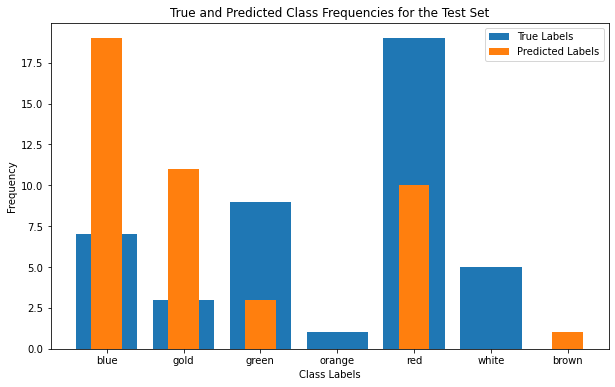

In [81]:
import matplotlib.pyplot as plt

################################################
# Your answer to Question 9.2(A) STARTS HERE
################################################
plt.figure(figsize=(10, 6))
true_labels, true_label_counts = np.unique(test_df["label"], return_counts=True)
predicted_labels, predicted_label_counts = np.unique(make_predictions(test_df, depth_3_tree), return_counts=True)

plt.bar(true_labels, true_label_counts, label="True Labels")
plt.bar(predicted_labels, predicted_label_counts, label="Predicted Labels", width=0.4)

plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.legend()
plt.title('True and Predicted Class Frequencies for the Test Set')
plt.show()
  

################################################
# Your answer to Question 9.2(A) ENDS HERE
################################################


**Type your text answers here**

**(B)**


From the histogram generated above, it is visible that 'white' and 'orange' labels are not being predicted, while the 'brown' label is being predicted even though there is no presence of it in the test set.
We can also see that that 'blue' and 'gold' are being predicted more often their true labels, while 'green' and 'red' are being predicted less often.

Labels with 'green','red', 'orange', and 'white' are probably being predicted as 'blue', 'gold' and 'brown', which could be the reason for latter being predicted more than the actual number of their true labels.

This is the depth 3 tree generated on the train set which was used to make predictions on the test set.

{'blue < 1': [{'red < 1': [{'orange < 1': ['green', 'brown']},
                           {'gold < 1': ['red', 'gold']}]},
              {'red < 1': [{'green < 1': ['blue', 'green']},
                           {'white < 1': ['gold', 'blue']}]}]}
                           
The decision tree reveals that the absence of 'orange' and 'white' labels within the leaf nodes indicates that the tree is not predicting these specific labels.                 
The training data set as well as the depth of the tree are quite small, with a very uneven composition of labels, so there is not enough information for predicted the labels accurately.

**(C)**

The Flags data set involves a multiclass classification problem and accuracy is not the most appropriate evaluation metric since the class distribution is imbalanced with an uneven composition of labels. 

There is an imbalance in the class distributions, with some label like 'blue' and 'red' being significantly more prevalent in the data set as compared to other classes. Furthermore, it may be the case that different features have different levels of importance when it comes to prediction. 

Accuracy also does not take into account true positives, false positives, and false negative, which could be more helpful when there is a class imbalance.


### Q9.3 Features (0.75 mark)

By looking at the `flags.names` file as well as your helper functions answer the following question. Feel free to implement gain ratio but you can answer this question intuitively too. 

**(A)** If we were to use `gain ratio` instead of `information gain`, which of the 25 attributes would be most affected? why? **0.75**

In [82]:
### CODE 9.3 optional code ###
for col in df.columns:
    most_distinct_value = df[col].value_counts().idxmax()
    num_distinct_values = df[col].nunique()
    print(f"{col} has {num_distinct_values} distinct values")
    
print()    
most_distinct_column = max(df, key=lambda col: df[col].nunique())
print(most_distinct_column,"has the most number of distinct values:", df[most_distinct_column].nunique())


landmass has 6 distinct values
zone has 4 distinct values
area has 5 distinct values
population has 5 distinct values
language has 10 distinct values
bars has 5 distinct values
stripes has 12 distinct values
colours has 8 distinct values
red has 2 distinct values
green has 2 distinct values
blue has 2 distinct values
gold has 2 distinct values
white has 2 distinct values
black has 2 distinct values
orange has 2 distinct values
circles has 4 distinct values
crosses has 3 distinct values
saltires has 2 distinct values
quarters has 3 distinct values
sunstars has 14 distinct values
crescent has 2 distinct values
triangle has 2 distinct values
icon has 2 distinct values
animate has 2 distinct values
text has 2 distinct values
label has 8 distinct values

sunstars has the most number of distinct values: 14


**Type your text answers here**

Using Gain Ration instead of Information Gain, reduces the bias for information gain towards highly branching attributes, i.e attributes with more distinct values, by normalising relative to the split information.

By looking through the flag.names file, it seems to be the case that the 'languages' feature has a high number of distinct values, with the number of values being 10, but after the analysing the data set, and calculating the distinct values for each, it turns out that the 'sunstars' feature has 14 distinct values, and therefore has the highest number of distinct values.

The 'sunstars' feature would be most affected as it has the highest number of distinct values, and gain ratio penalizes attributes with a large number of values, by normalising relative to the split information.



### Q9.4 Decision tree complexity (1 mark)

**(A)** Using the tree you generated in Q8 (name it `little_tree`), find the accuracy of the tree for predicting the labels for the **training set**. Do you notice a difference between train and test accuracy? If so, discuss possible reasons. 

**(B)** Now change the max_depth of the decision tree to 10 and train another tree (name it `big_tree`). Now use this new tree to predict the labels for test and train sets. Describe and explain any change in the results you notice compared to your tree of depth 3.


In [83]:
### CODE 9.4 (A) ###
little_tree = depth_3_tree
accuracy_little_tree_train = calculate_accuracy(train_df, make_predictions(train_df, little_tree))
accuracy_little_tree_test = calculate_accuracy(test_df, make_predictions(test_df, depth_3_tree))
print("accuracy_little_tree_train: ", accuracy_little_tree_train)
print("accuracy_little_tree_test: ", accuracy_little_tree_test)
# pprint(little_tree)

accuracy_little_tree_train:  0.5266666666666666
accuracy_little_tree_test:  0.4318181818181818


In [84]:
### CODE 9.4 (B) ###
big_tree = decision_tree_algorithm(data=train_df.values, array=train_df.columns, max_depth=10, counter=0)
accuracy_big_tree_train = calculate_accuracy(train_df, make_predictions(train_df, big_tree))
accuracy_big_tree_test = calculate_accuracy(test_df, make_predictions(test_df, big_tree))
print("accuracy_big_tree_train: ", accuracy_big_tree_train)
print("accuracy_big_tree_test: ", accuracy_big_tree_test)
# print(big_tree)

accuracy_big_tree_train:  1.0
accuracy_big_tree_test:  0.45454545454545453


**Type your text answers here**

**(A)**

The difference between the train and test accuracies may be due to the tree being trained to a depth of 3, resulting in it being quite shallow and underfitting the data. It is not able to generate appropriate patterns from the train set to make accurate predictions on the test set, which could be resulting in a lower accuracy for the test set as compared to the train set. The training data is limited with only 150 instances, which could lead to the model memorizing instead of generalising based on patterns.

There also seems to be a presence of an imbalance of classes, with the distibution of classes in the training and test data being different, and decision tree model may be predicting the majority classes better on the training set, while failing to generalise to the minority in the test set.

Another possible reason could due to feature variability, with some features not being well represented in the train set, affecting the predication capability in the test set.

**(B)**

Changing the max_depth of the tree to 10, the accuracy of the training set has increased significantly, and it predicts labels of the training data accurate with a accuracy of 1 or 100%. There is a slight increase in the accuracy of prediction on the test set to 0.45, but not very significant, and is not able to predict the labels for new instances very well. 

This could be a result of overfitting, and the model has captured more intricate patterns in the training data, but the improvement towards its test set accuracy is still relatively low, indicating that it is also not generalising well to new data. 

The tree has also likely learned noise and outliers present in the training data, which is why it achieves this perfect accuracy, but does not perform well on the test data.  

# Authorship Declaration:

   (1) I certify that the program contained in this submission is completely
   my own individual work, except where explicitly noted by comments that
   provide details otherwise.  I understand that work that has been developed
   by another student, or by me in collaboration with other students,
   or by non-students as a result of request, solicitation, or payment,
   may not be submitted for assessment in this subject.  I understand that
   submitting for assessment work developed by or in collaboration with
   other students or non-students constitutes Academic Misconduct, and
   may be penalized by mark deductions, or by other penalties determined
   via the University of Melbourne Academic Honesty Policy, as described
   at https://academicintegrity.unimelb.edu.au.

   (2) I also certify that I have not provided a copy of this work in either
   softcopy or hardcopy or any other form to any other student, and nor will
   I do so until after the marks are released. I understand that providing
   my work to other students, regardless of my intention or any undertakings
   made to me by that other student, is also Academic Misconduct.

   (3) I further understand that providing a copy of the assignment
   specification to any form of code authoring or assignment tutoring
   service, or drawing the attention of others to such services and code
   that may have been made available via such a service, may be regarded
   as Student General Misconduct (interfering with the teaching activities
   of the University and/or inciting others to commit Academic Misconduct).
   I understand that an allegation of Student General Misconduct may arise
   regardless of whether or not I personally make use of such solutions
   or sought benefit from such actions.

   <b>Signed by</b>: [Kian Dsouza - 1142463]
   
   <b>Dated</b>: [11/08/2023]